# <p style="text-align:center;"><span style="font-size:48px;"><span style="color:#907FFB;"><span style="font-family:cursive;"> Mask And Face Disease Detection</span> </span>  </span></p>

![image](https://www.romsons.in/cdn/shop/products/face-masks_1_800x.jpg?v=1649141074)

<a id="contents_tabel"></a>
<div style="border-radius:10px; padding: 15px; background-color: #FFF545; font-size:115%; text-align:left">

<h3 align="left"><font color=black>Table of Contents :</font></h3>

* [Phase 1 : Import & Install Libraries](#import)    
* [Phase 2 : About Dataset](#about)
    - [Phase 2.1 : Import Dataset](#importdata)
    - [Phase 2.2 : About Shape and Number](#features)
* [Phase 3 : EDA ( Exploratory data analysis ) On Dataset](#eda)
* [Phase 4 : Data Preprocessing](#prep)
    - [Phase 4.1 : Train, Test, Validation Split](#ttsplit)
    - [Phase 4.2 : Data Augmentation](#aug)
* [Phase 5 : Prepare Network](#net)
* [Phase 6 : Prepare Train Objects](#trainobj)    
* [Phase 7 : Train](#train)    

<a id="import"></a>
# <p style="background-color:#afeff9; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:center; border-radius:200px 200px;">Phase 1 : Import & Install Libraries</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [1]:
# Main Works
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

# EDA
import cv2
import glob

# Visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Model Structured
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Training Objects
from tensorflow.keras.callbacks import EarlyStopping

# Train
from tensorflow.keras.callbacks import ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<a id="importdata"></a>
## <p style="background-color:#23ff16; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:left; border-radius:200px 200px;">Phase 2.1 : Import Dataset</p>

⬆️ [Tabel of Contents](#contents_tabel)

Datasets :

In [8]:
dataset_mask = {}
for class_name in glob.glob('/kaggle/input/face-mask-detection/Dataset/*'):
        dataset_mask[class_name.split('/')[-1]] = glob.glob(class_name + '/*')

Classes :

In [9]:
dataset_mask.keys()

dict_keys(['without_mask', 'mask_weared_incorrect', 'with_mask'])

<a id="features"></a>
## <p style="background-color:#23ff16; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:left; border-radius:200px 200px;">Phase 2.2 : About Shape and Number</p>

⬆️ [Tabel of Contents](#contents_tabel)

[2994, 2994, 2994]
dict_keys(['without_mask', 'mask_weared_incorrect', 'with_mask'])


<BarContainer object of 3 artists>

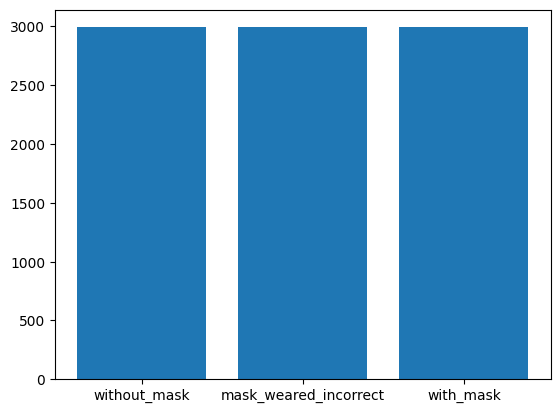

In [7]:
x = dataset_mask.keys()
y = [len(number) for number in dataset_mask.values()]
print(y)
print(x)

plt.bar(x, y)

In [7]:
def get_dims(file):
    '''Returns dimenstions for an image'''
    image = cv2.imread(file)    
    h, w, d = image.shape
    return h, w, d

In [10]:
df = pd.DataFrame(columns=['Height',
                           'Width',
                           'Channels',
                           'Class'])

for class_name in dataset_mask.keys():
    for path in dataset_mask[class_name]:
        h, w, d = get_dims(path)
        df.loc[len(df)] = [h, w, d, class_name]

df

,Height,Width,Channels,Class
0,128,128,3,without_mask
1,128,128,3,without_mask
2,128,128,3,without_mask
3,128,128,3,without_mask
4,128,128,3,without_mask
...,...,...,...,...
8977,128,128,3,with_mask
8978,128,128,3,with_mask
8979,128,128,3,with_mask
8980,128,128,3,with_mask


In [11]:
fig = px.scatter_3d(df, x='Height', y='Width', z='Channels', color='Class', symbol='Class',
                    labels={'Height':'Height', 'Width':'Width', 'Channels':'Channels'},
                    title='3D Scatter plot of Image Dimensions by Class')

fig.show()

<a id="eda"></a>
# <p style="background-color:#afeff9; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:center; border-radius:200px 200px;">Phase 3 : EDA ( Exploratory data analysis ) On Dataset</p>

⬆️ [Tabel of Contents](#contents_tabel)

<p style="background-color:#efeeee; padding: 15px; font-family:cursive; color:black; font-size:200%; text-align:center; border-radius:200px 200px;">Show some data</p>

In [15]:
def plot_sample(dataset, size, figsize):
    count = 0
    plt.figure(figsize=figsize)
    for class_type in dataset.keys():    
        for path in dataset[class_type]:                
            sp = plt.subplot(size[0], size[1], count + 1, )
            sp.axis('Off')
            sp.set_title(class_type)        
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            count += 1
            if count % 4 == 0:            
                break
    plt.show()

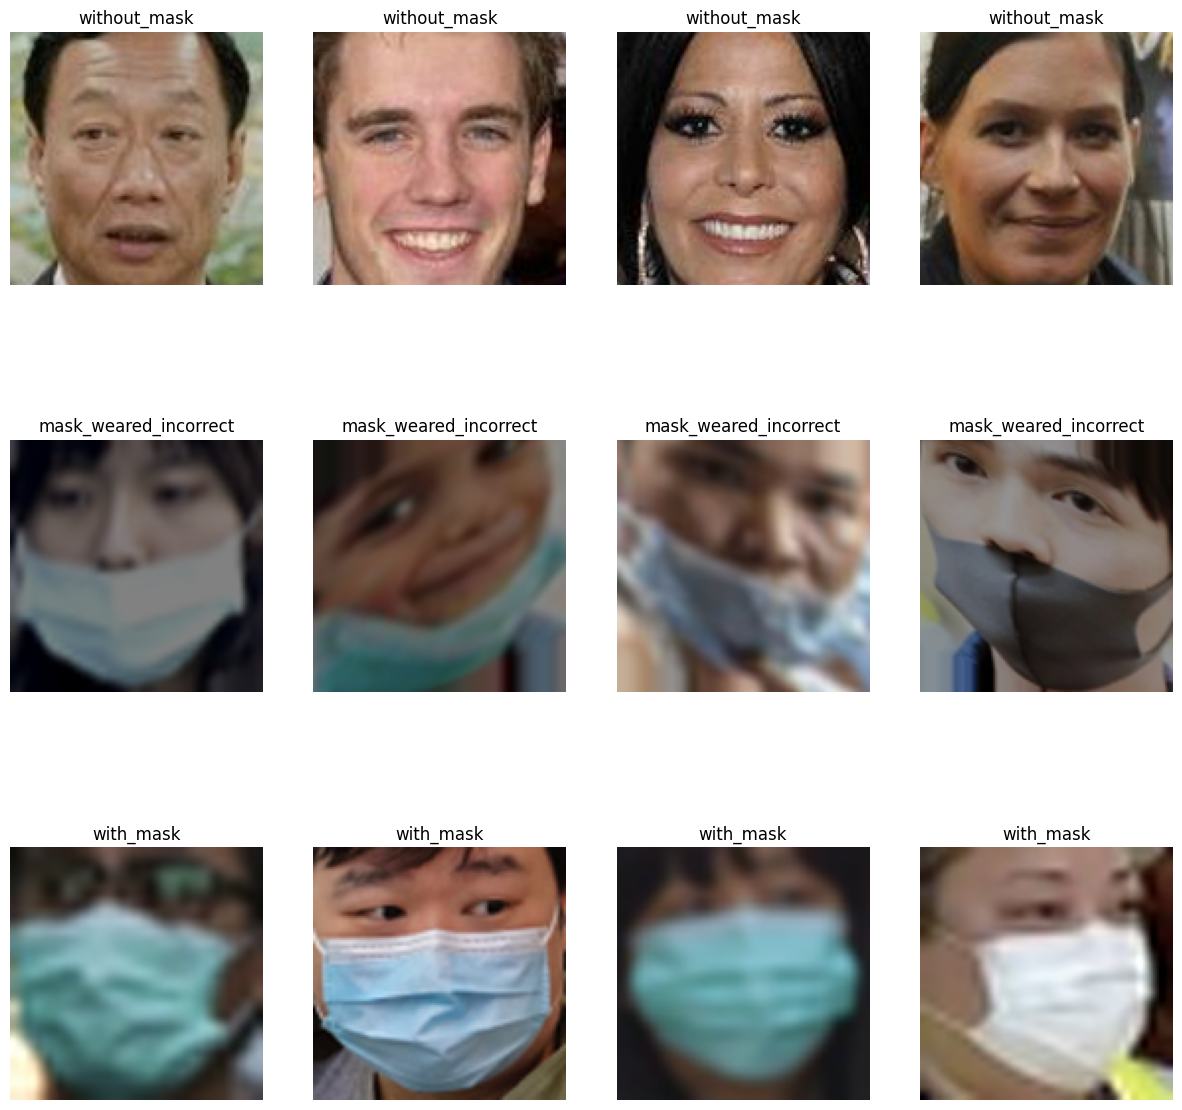

In [19]:
plot_sample(dataset_mask, [len(dataset_mask.keys()), 4], (15, 15))

<p style="background-color:#efeeee; padding: 15px; font-family:cursive; color:black; font-size:200%; text-align:center; border-radius:200px 200px;">Check contrast</p>

In [25]:
def compute_mean_histogram(image_paths):
    try:
        histograms = {'red': [], 'green': [], 'blue': []}
        for image_path in image_paths:
            image = cv2.imread(image_path)  # Load image in color mode
            for i, color in enumerate(('blue', 'green', 'red')):
                hist = cv2.calcHist([image], [i], None, [256], [0, 256])
                histograms[color].append(hist)
        mean_histograms = {color: np.mean(hists, axis=0) for color, hists in histograms.items()}
        return mean_histograms
    except:
        pass

In [ ]:
mean_histograms_per_class = {}
for class_label, image_paths in dataset_mask.items():
    mean_histograms_per_class[class_label] = compute_mean_histogram(image_paths)

In [24]:
# Plotting
fig = go.Figure()
for class_label, mean_histograms in mean_histograms_per_class.items():
    for color, mean_histogram in mean_histograms.items():
        fig.add_trace(go.Scatter(x=np.arange(256), y=mean_histogram.flatten(), mode='lines', name=f'{class_label} - {color}'))

fig.update_layout(
    title='Mean Histograms per Class per Channel',
    xaxis_title='Pixel Value',
    yaxis_title='Frequency',
    legend_title='Class - Channel'
)
fig.show()

<p style="background-color:#efeeee; padding: 15px; font-family:cursive; color:black; font-size:200%; text-align:center; border-radius:200px 200px;">Check Standard Deviation</p>

In [34]:
def compute_avg_std(image_paths):
    stds = {'red': [], 'green': [], 'blue': []}
    for image_path in image_paths:
        image = cv2.imread(image_path)  # Load image in color mode
        for i, color in enumerate(('blue', 'green', 'red')):
            std = np.std(image[:,:,i])
            stds[color].append(std)
    avg_stds = {color: np.mean(values) for color, values in stds.items()}
    return avg_stds

In [ ]:
avg_stds_per_class = {}
for class_label, image_paths in dataset_mask.items():
    avg_stds_per_class[class_label] = compute_avg_std(image_paths)

In [29]:
# Plotting
categories = list(avg_stds_per_class.keys())
fig = go.Figure()
for color in ['red', 'green', 'blue']:
    values = [avg_stds_per_class[class_label][color] for class_label in categories]
    fig.add_trace(go.Bar(x=categories, y=values, name=f'{color} channel'))

fig.update_layout(
    title='Average Standard Deviation of Pixel Values per Class per Channel',
    xaxis_title='Class',
    yaxis_title='Average Standard Deviation',
    legend_title='Channel'
)
fig.show()

<p style="background-color:#efeeee; padding: 15px; font-family:cursive; color:black; font-size:200%; text-align:center; border-radius:200px 200px;">Check Noise Level</p>

In [37]:
def estimate_noise(image_paths):
    noise_levels = []
    for image_path in image_paths:
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
        laplacian = cv2.Laplacian(image, cv2.CV_64F)
        std_dev = np.std(laplacian)
        noise_levels.append(std_dev)
    mean_noise_level = np.mean(noise_levels)
    return mean_noise_level

In [ ]:
mean_noise_levels = {}
for class_label, image_paths in dataset_mask.items():
    mean_noise_levels[class_label] = estimate_noise(image_paths)

In [34]:
# Plotting
fig = go.Figure()
class_labels = list(mean_noise_levels.keys())
noise_levels = list(mean_noise_levels.values())
fig.add_trace(go.Bar(x=class_labels, y=noise_levels))
fig.update_layout(
    title='Estimated Noise Levels per Class',
    xaxis_title='Class',
    yaxis_title='Estimated Noise Level',
    legend_title='Class'
)
fig.show()

<a id="prep"></a>
# <p style="background-color:#afeff9; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:center; border-radius:200px 200px;">Phase 4 : Data Preprocessing</p>

⬆️ [Tabel of Contents](#contents_tabel)

<a id="ttsplit"></a>
## <p style="background-color:#23ff16; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:left; border-radius:200px 200px;">Phase 4.1 : Train, Test, Validation Split</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [3]:
directory_path = '/kaggle/input/face-mask-detection/Dataset'
image_size = (224, 224)
batch_size = 64  

# Create the training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=directory_path,
    validation_split=0.3,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=directory_path,
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 8982 files belonging to 3 classes.
Using 6288 files for training.
Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


In [5]:
# Get the number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into validation and test datasets
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

<a id="aug"></a>
## <p style="background-color:#23ff16; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:left; border-radius:200px 200px;">Phase 4.4 : Data Augmentation</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [7]:
data_augmentation = tf.keras.Sequential([    
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [8]:
# Apply other augmentations only to the training dataset
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [10]:
def one_hot_encode(image, label):
    return image, tf.one_hot(label, depth=3)

train_ds_one_hot = augmented_train_ds.map(one_hot_encode)
val_ds_one_hot   = val_ds.map(one_hot_encode)
test_ds_one_hot  = test_ds.map(one_hot_encode)

<a id="net"></a>
# <p style="background-color:#afeff9; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:center; border-radius:200px 200px;">Phase 5 : Prepare Network</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [12]:
base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [40]:
base_model.summary()

Model: "inception_v3"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_5[0][0]']                

                                )                                                                 

                                                                                                  

 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 

 alization)                     )                                           

In [24]:
base_model.trainable = False

Feature_Extractor = Sequential([
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.Rescaling(1./255),    
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
])

Classifier = Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),    
    tf.keras.layers.Dense(3, activation='softmax'),
])


In [53]:
input = tf.keras.Input(shape=(None, None, 3))

shared = Feature_Extractor(input)

output = Classifier(shared)

model = tf.keras.Model(inputs=input, outputs=output)

In [54]:
model.build((None, None, None, 3))

In [31]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 sequential_7 (Sequential)   (None, 2048)              21802784  
                                                                 
 sequential_8 (Sequential)   (None, 3)                 2240291   
                                                                 
Total params: 24,043,075
Trainable params: 2,240,291
Non-trainable params: 21,802,784
_________________________________________________________________


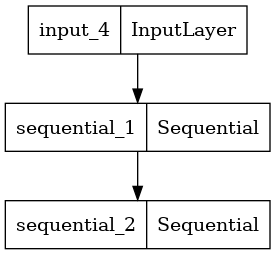

In [18]:
plot_model(model_T1)

<a id="trainobj"></a>
# <p style="background-color:#afeff9; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:center; border-radius:200px 200px;">Phase 6 : Prepare Train Objects</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [27]:
OPTIMIZER  = tf.keras.optimizers.Adam(learning_rate=0.015,
                                    amsgrad=True,
                                    weight_decay=0.05)

LOSS       = tf.keras.losses.CategoricalCrossentropy()

METRICS    = [tf.keras.metrics.CategoricalAccuracy(),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.Precision(name='precision')]

EARLYSTOPPING = EarlyStopping(monitor='val_categorical_accuracy',
                            min_delta=0.001,
                            patience=10,
                            verbose=0,
                            mode='max',
                            baseline=0.9,
                            restore_best_weights=True,
                            start_from_epoch=1)

CHECKPOINT = ModelCheckpoint('mask_detection.h5',                                                          
                            monitor='val_categorical_accuracy',
                            verbose=0,
                            mode='max',
                            save_best_only=True)


model.compile(optimizer=OPTIMIZER,
            loss=LOSS,
            metrics=METRICS)

<a id="train"></a>
# <p style="background-color:#afeff9; padding: 15px; font-family:cursive; color:black; font-size:100%; text-align:center; border-radius:200px 200px;">Phase 7 : Train</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [28]:
history = model.fit(train_ds_one_hot,
                    callbacks=[CHECKPOINT, EARLYSTOPPING],
                    epochs=100,
                    validation_data=val_ds_one_hot)

Epoch 1/100
99/99 [==============================] - 84s 781ms/step - loss: 1.4499 - categorical_accuracy: 0.3958 - recall: 0.1191 - precision: 0.4867 - val_loss: 1.0712 - val_categorical_accuracy: 0.3230 - val_recall: 0.0199 - val_precision: 1.0000
Epoch 2/100
99/99 [==============================] - 79s 793ms/step - loss: 0.7995 - categorical_accuracy: 0.5590 - recall: 0.3580 - precision: 0.7176 - val_loss: 0.5454 - val_categorical_accuracy: 0.6726 - val_recall: 0.4801 - val_precision: 0.7509
Epoch 3/100
99/99 [==============================] - 78s 784ms/step - loss: 0.6407 - categorical_accuracy: 0.6398 - recall: 0.5068 - precision: 0.7045 - val_loss: 0.5183 - val_categorical_accuracy: 0.7124 - val_recall: 0.6438 - val_precision: 0.7386
Epoch 4/100
99/99 [==============================] - 79s 799ms/step - loss: 0.6403 - categorical_accuracy: 0.6597 - recall: 0.5536 - precision: 0.7075 - val_loss: 0.4820 - val_categorical_accuracy: 0.8031 - val_recall: 0.7478 - val_precision: 0.8244


In [29]:
from IPython.display import FileLink

In [30]:
%cd /kaggle/working/

/kaggle/working


In [32]:
FileLink('mask_detection.h5')

/kaggle/working/mask_detection.h5